__Задание 1: взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)__


__Решение:__ я скачал себе в Gogle Collab датасет
Occupancy Detection Data Set и буду считывать его из своего хранилища <br>
 https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+ 

Информация о наборе данных:

Представлено два набора данных для обучения и тестирования. Фактическая занятость была получена из снимков с отметками времени, которые делались каждую минуту.


Информация об атрибутах:

* __date:__ дата время год-месяц-день час:минута:секунда
* __Temperature:__ температура по Цельсию
* __Humidity:__ Относительная влажность, %
* __Light:__ oсвещенность, в люксах
* __CO2:__ CO2, в ppm
* __HumidityRatio:__ oтношение влажности, вычисленное по температуре и относительной влажности, в кг водяного пара/кг воздуха
* __Occupancy:__ целевая переменная, обозгначающая занятость помещения, 0 или 1, 0 для не занято, 1 для состояния занятости


In [275]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [276]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score, f1_score

with open('/content/drive/MyDrive/ГБ/выборки для исследований/datatraining.txt', "rb") as f:
    data_train = pd.read_csv(f, sep=',')

with open('/content/drive/MyDrive/ГБ/выборки для исследований/datatest.txt', "rb") as f1:
    data_test = pd.read_csv(f1, sep=',')

# проверяем не съехали ли колонки
data_train.head(6)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1
6,2015-02-04 17:55:59,23.10,27.2000,419.0,701.00,0.004757,1


In [277]:
# проверяем не съехали ли колонки
data_test.head(3)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.700,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.718,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.730,26.230,572.666667,769.666667,0.004765,1


__Задание 2: сделать обзорный анализ выбранного датасета (EDA)__

__Решение__

Проверим есть ли дубликаты строк в обучающих данных

In [278]:
data_train[data_train.duplicated()]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy


Дубликатов нет. Проверим наличие пропусков:

In [279]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


Всего 8143 строки и по всех столбцах значения заполнены - пропусков нет.

Посмотрим на сбалансированность датасета:

In [280]:
data_train.Occupancy.value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

Имеем несбалансированный набор данных, всего классов два.

Изучим распределения каждого количественных признаков. <br>

P.S.: первый признак date можно было бы преобразовать в категориальный тип данных - по месяцам и отдельно выделить категориальный признак периода времени дня - с 9-00 до 19-00 и остально диапазон (поэкспериментировать с кол-вом периодов). Поскольку вероятно признак температуры будет не очень информативен летом при пустом помещении, когда итак жарко, и например зимой при полном кабинете.

Но пока я его просто не буду принимать во внимание и посмотрю как модель справится без него.

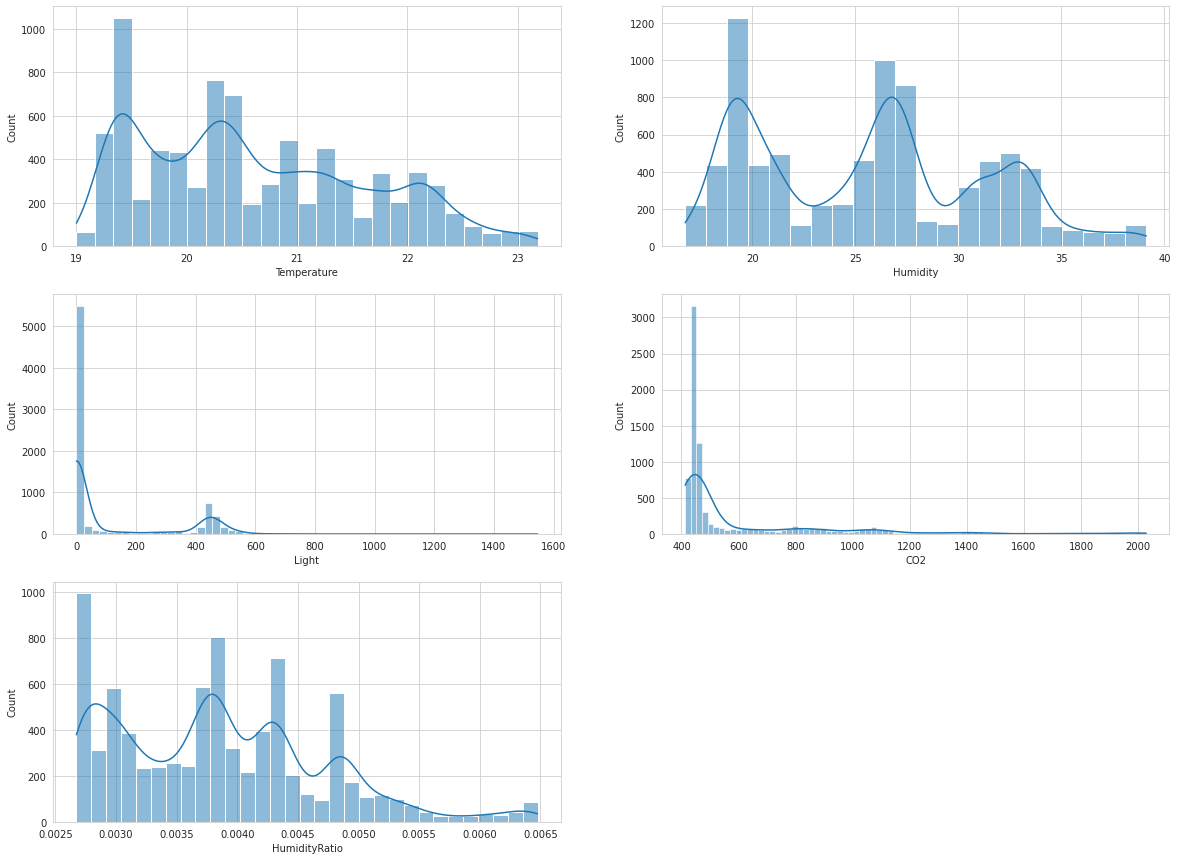

In [281]:
feauture_to_show = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']


sns.set_style('whitegrid')

plt.figure(figsize=(20, 15))
for i in range(len(feauture_to_show)):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=data_train, x=feauture_to_show[i], kde=True)

В CO2 и Light как-будто бы есть выбросы, т.к. график далеко тянется низко вправо

Посмотрим на распределения признаков с привязкой к классам:

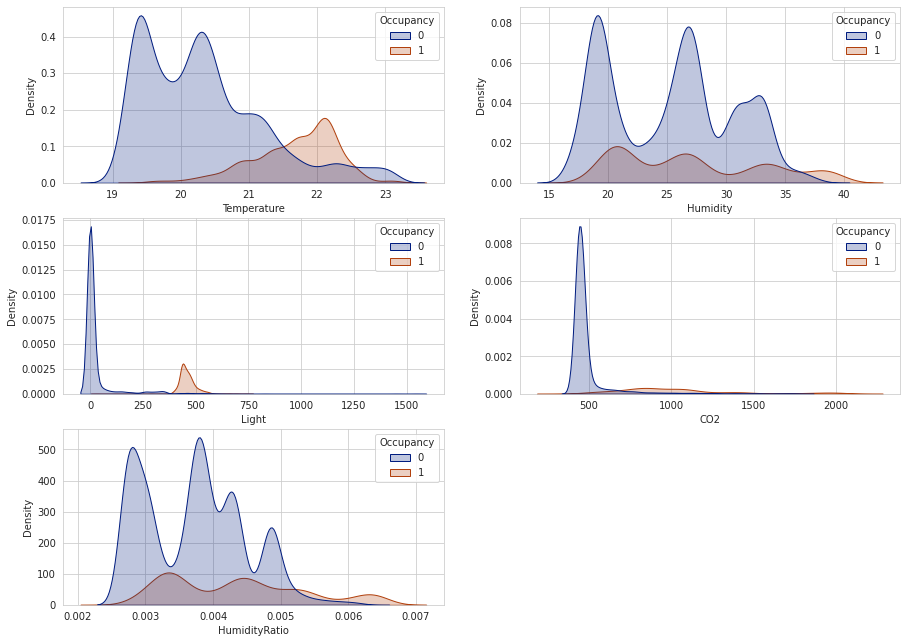

In [282]:
plt.figure(figsize=(15, 11))
for i in range(len(feauture_to_show)):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(data=data_train, x=feauture_to_show[i], hue='Occupancy', fill=True, palette='dark')


На графике признака Light видно что можно с минимальными потерями определять класс лишь по этому признаку (где-то в районе значения 375 можно провести разделительную черту)

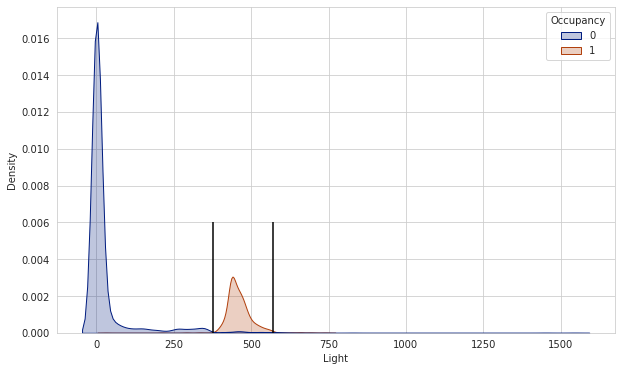

In [283]:
#проверим нашу теорию
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_train, x=data_train.Light, hue='Occupancy', fill=True, palette='dark')
plt.vlines(375, 0, 0.006)  # методом подбора приблизил линию к точке разграничения
plt.vlines(570, 0, 0.006)  # методом подбора приблизил линию к точке разграничения


Посмотрим кусок правой части, после 570, есть ли там первый класс

1    21
0    14
Name: Occupancy, dtype: int64


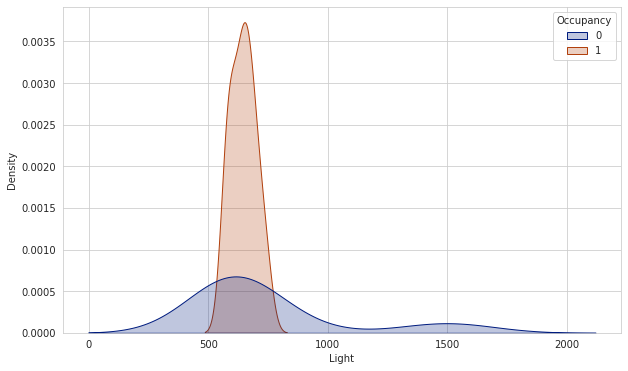

In [284]:
part_of_data = data_train.loc[data_train.Light > 570, :]
print(part_of_data.Occupancy.value_counts())

plt.figure(figsize=(10, 6))
sns.kdeplot(data=part_of_data, x=part_of_data.Light, hue='Occupancy', fill=True, palette='dark')

Таким образом, все же первый класс встречается после значения у признака Light > 570, но редко.

Все же попробуем ради любопытства проверить метрики при предсказании класса только лишь за счет признака Light:

In [285]:
data_train['y_pred'] = 0
data_train.loc[(data_train.Light > 375) & (data_train.Light < 570), 'y_pred'] = 1
r2_score(data_train['Occupancy'],data_train['y_pred']) , f1_score(data_train['Occupancy'],data_train['y_pred'])

(0.9199637036031109, 0.9688660382747787)

In [286]:
# Проверим на тесте
data_test['y_pred'] = 0
data_test.loc[(data_test.Light > 375) & (data_test.Light < 570), 'y_pred'] = 1
r2_score(data_test['Occupancy'],data_test['y_pred']) , f1_score(data_test['Occupancy'],data_test['y_pred'])

(0.666388348051405, 0.887308533916849)

Доля объясненной дисперсии на тестовых данных уменьшилась, но f мера выдает неплохой результат. Если заказчик ограничен в бюджете, чтобы не терять клиента, можно предложить ему сопровождение бизнес-процессов с использованием дешевого подхода к анализу данных.

In [287]:
# удалим наше баловство 
data_train.drop(columns='y_pred', inplace=True)
data_test.drop(columns='y_pred', inplace=True)

В завершении EDA посмотрим на наличие выбросов в каждом из признаков:

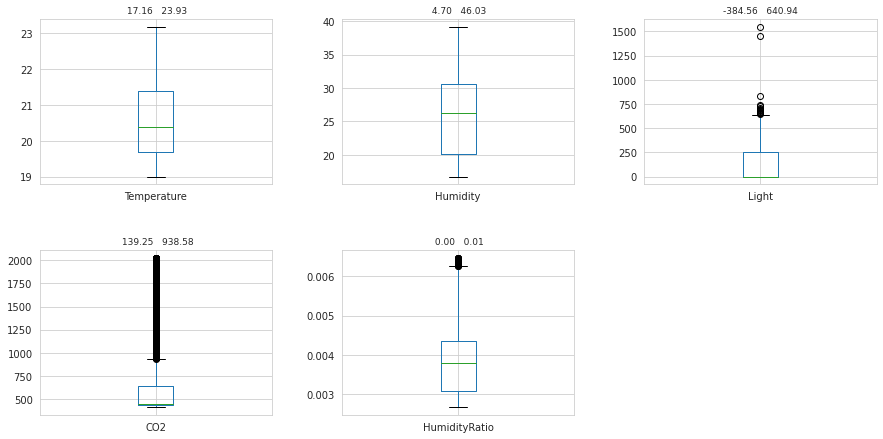

In [288]:
def func_boxplots(li_st, data_train):
    fig = plt.figure(figsize=(15,20))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.rc('axes', titlesize=9)  # размер границ выбросов
    plt.rc('xtick', labelsize=10)  # размер признака
    count = 1
    for i in li_st:
        ax = fig.add_subplot(5, 3, count)
        data_train.boxplot(column=i)
        
        IQR = data_train[i].quantile(0.75) - data_train[i].quantile(0.25)
        lower_bound = data_train[i].quantile(0.25)-1.5*IQR
        upper_bound = data_train[i].quantile(0.75)+1.5*IQR
        plt.title(f'{lower_bound: .2f}  {upper_bound: .2f}')
        
        count += 1
        

func_boxplots(feauture_to_show, data_train)


В CO2 казалось бы много выбросов, но чтобы достоверно считать показание свыше 938 выбросами нужно изучить природу CO2 в промышленных помещениях, вероятно сопоставить типы помещений и кол-во людей и тп.

__Задание 3: сделать feature engineering__

__Решение:__ Попробуем пойти по простому пути и просто на первом этапе ограничимся масштабированием признаков (не будем применять полиному, скрещивания признаков и тп.)

In [289]:
list(data_train.columns[1:-1]),print(feauture_to_show)

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']


(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], None)

In [290]:
class ColumnSelector(BaseEstimator, TransformerMixin):  # класс для выбора столбцов для помещения их в пайпы  обработки признаков
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
        

# пайп обработки колич. признаков
preprocessing =  Pipeline([
    ('selector', ColumnSelector(column=feauture_to_show)),
    ('scaler', MinMaxScaler())
        ])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', LogisticRegression(random_state=1))
])

__Задание 4: обучить любой классификатор (какой вам нравится)__

__Решение__  выше выбрал лог. регрессию

In [291]:
y = data_train.Occupancy
X = data_train.drop(columns='Occupancy')
X.drop(columns='date', inplace=True) # тоже удаляем, т.к. решил без него пока работать

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

pipe.fit(X_train, y_train)

predict_train = pipe.predict_proba(X_train)[:,1]
predict_test = pipe.predict_proba(X_test)[:,1]
predict_test2 = pipe.predict_proba(data_test[feauture_to_show])[:,1]


In [292]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

results = pd.DataFrame(columns=['thresh', 'ix', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])

def compute_result(y_true, preds_proba, results):
    precision, recall, thresholds = precision_recall_curve(y_true, preds_proba)
    fscore = (2 * precision * recall) / (precision + recall)
    auc = roc_auc_score(y_true, preds_proba)
    ix = np.argmax(fscore)

    results = results.append({
      'thresh': thresholds[ix],
      'ix': ix,
      'F-Score': fscore[ix],
      'Precision': precision[ix],
      'Recall': recall[ix],
      'ROC AUC': auc
      }, ignore_index=True)
    
    return results


results = compute_result(y_train, predict_train, results)


invalid value encountered in true_divide


In [293]:
results = compute_result(y_test, predict_test, results)


invalid value encountered in true_divide


In [294]:
results = compute_result(data_test.Occupancy, predict_test2, results)

In [295]:
results

,thresh,ix,F-Score,Precision,Recall,ROC AUC
0,0.999998,1523.0,NaN,0.000000,0.000000,0.994372
1,0.999995,456.0,NaN,0.000000,0.000000,0.993479
2,0.265165,22.0,0.971486,0.945472,0.998971,0.991919


Опять эти NaN, нотбук ругается на invalid value encountered in true_divide, не пойму что не так. <br>

Перейдем к след. этапу, посмотрим насколько переобученной получилась модель:

In [296]:
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print(f'train r2: {r2_score(y_train, pred_train)} , f1 score: {f1_score(y_train, pred_train)}')
print(f'test  r2: {r2_score(y_test, pred_test)} , f1 score: {f1_score(y_test, pred_test)}')


train r2: 0.9177251976566049 , f1 score: 0.9682539682539681
test  r2: 0.9237342223515665 , f1 score: 0.9705215419501133


Модель выдает отличные результаты и не показывает переобучение.<br> 

Теперь оценим качество работы модели по сравнении с методом, когда мы только лишь по значению признака Light определяли выше класс:

In [297]:
pred_test = pipe.predict(data_test[feauture_to_show])


r2_score(data_test['Occupancy'], pred_test) , f1_score(data_test['Occupancy'], pred_test)

#метрика метода через только лишь признак Light
# (0.666388348051405, 0.887308533916849)

(0.9060705057620461, 0.9709418837675351)

Очевидно, что модель МО справляется с задачей лучше.

__Задание 5:__ 
* разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%


In [298]:
!pip install shap xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


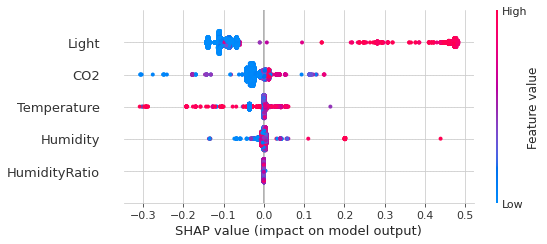

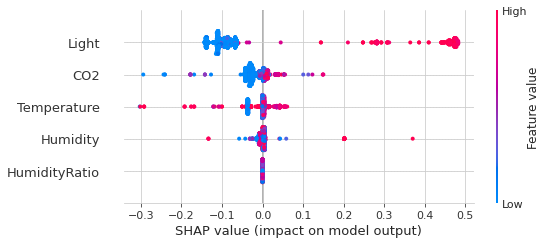

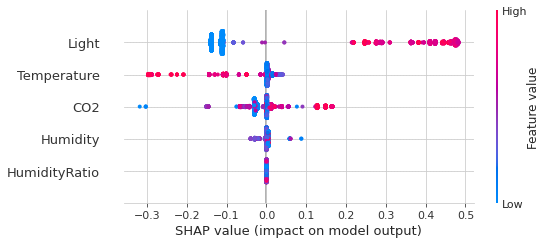

In [299]:
import shap
import xgboost


# из документации
# xgboost.train(params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, 
#               evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

# params (Dict[str, Any]) – Booster params.
# dtrain (DMatrix) – Data to be trained.
# num_boost_round (int) – Number of boosting iterations.

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)



#plt.figure(figsize=(15, 20))

# смотрим важность признаков на обучающем наборе
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# смотрим важность признаков на тестовом наборе
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# смотрим важность признаков на отдельном тестовом наборе, но сначала отмасштабируем признаки как это сделано в X_train и X_test
# сначала нужно обработать признаки в тестовом наборе
shap_values = explainer.shap_values(data_test[feauture_to_show])
shap.summary_plot(shap_values, data_test[feauture_to_show])





Таким образом видим что три наиболее важных признака это Свет, Температура и Углекислый газ. <br>

Наиболее важный свет, впрочем мы в этом убедились ранее. 

Температура и свет чередуются между собой по важности как это видно в сравнении X_test и data_test

Для топ 10% показать график непонятно как это реализовывается, т.к. shap_values это вектор кажности каждого признака по каждой строке наблюдения. Как список сортировать 

In [300]:
shap_values

array([[-2.2477013e-01, -1.6432527e-02,  2.5748369e-01, -1.6025036e-03,
        -1.9663244e-06],
       [-2.2477013e-01, -1.6432527e-02,  2.5748369e-01, -1.6025036e-03,
        -1.9663244e-06],
       [-2.2477013e-01, -1.6432527e-02,  2.5748369e-01, -1.6025036e-03,
        -1.9663244e-06],
       ...,
       [-1.0489937e-01, -2.5108207e-03,  3.8144305e-01,  1.6583201e-01,
        -1.9663244e-06],
       [-1.0489937e-01, -2.5108207e-03,  3.8144305e-01,  1.6583201e-01,
        -1.9663244e-06],
       [-1.0489937e-01, -2.5108207e-03,  3.8144305e-01,  1.6583201e-01,
        -1.9663244e-06]], dtype=float32)

Видимо имелось ввиду отсортировать датафрейм со значениями шепли по какому-то одному признаку и взять 10% от отсортированного

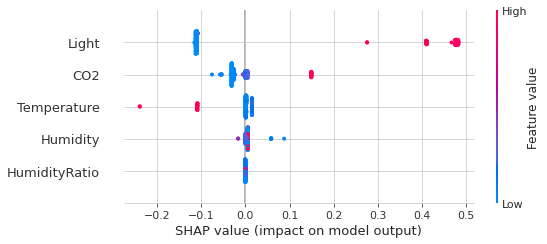

In [301]:
data = pd.DataFrame(shap_values, columns=feauture_to_show).sort_values(by=feauture_to_show[2], ascending = False)
n = int(data.shape[0] * 0.1)

indx_list = data[:n].index
new_shap_values = explainer.shap_values(data_test[feauture_to_show].loc[indx_list, :])
shap.summary_plot(new_shap_values, data_test[feauture_to_show].loc[indx_list, :]) 



На получившемся графике видим что CO2 все же важнее чем Температура и что Свет также самый полезный признах, Причем в остальным 4 признаках встречаются экземляры первого класса при значениях Шепли чуть больше нуля, в со светом разграничение более четкое. Также видим разграничения и по показателям температуры - если значение шепли ниже 0, то нулевой класс.

__Дополнительное задание от себя - проверить важность признаков CO2 и Temperature методом permutation importance__

__Решение__  суть метода в том, чтобы добавить шума в тестируемый признак (можно точечно перемешать значения признака без сортировки строк датасета) и проверить изменения метрик работы модели МО.

Тестить буду на X_test

In [302]:
# делаю копию, чтобы можно было возвращаться к исходнику
X_test_copy = X_test.copy()

# перемешиваю значения кислорода (вношу хаос в признак)
np.random.shuffle(X_test_copy.CO2.values)

In [303]:
pred_test = pipe.predict(X_test)
pred_CO2_shuffled = pipe.predict(X_test_copy)

print(f'original metrics: r2: {r2_score(y_test, pred_test)} , f1 score: {f1_score(y_test, pred_test)}')
print(f'CO2_shuffled metrics:  r2: {r2_score(y_test, pred_CO2_shuffled)} , f1 score: {f1_score(y_test, pred_CO2_shuffled)}')




original metrics: r2: 0.9237342223515665 , f1 score: 0.9705215419501133
CO2_shuffled metrics:  r2: 0.530672137548102 , f1 score: 0.8090692124105011


In [304]:
# делаю копию, чтобы можно было возвращаться к исходнику
X_test_copy2 = X_test.copy()

# перемешиваю значения кислорода (вношу хаос в признак)
np.random.shuffle(X_test_copy2.Temperature.values)

In [305]:
pred_Temperature_shuffled = pipe.predict(X_test_copy2)

print(f'original metrics: r2: {r2_score(y_test, pred_test)} , f1 score: {f1_score(y_test, pred_test)}')
print(f'Temperature_shuffled metrics:  r2: {r2_score(y_test, pred_Temperature_shuffled)} , f1 score: {f1_score(y_test, pred_Temperature_shuffled)}')

original metrics: r2: 0.9237342223515665 , f1 score: 0.9705215419501133
Temperature_shuffled metrics:  r2: 0.9090677266499447 , f1 score: 0.9646522234891676


Таким образом, с помощью метода permutation importance мы выяснили что признак CO2 важнее Температуры, т.к. модель более стабильно работает с зашумленным признаком температуры

__Задание 6: для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат.__

__Решение__

In [306]:
# строить force_plot буду по отдельным строкам (например в X_test 7699	и 3681 индексы это первые две строки - 0 и 1)

# посмотрим на них
X_test.head(4)


,Temperature,Humidity,Light,CO2,HumidityRatio
7699,20.290000,32.933333,0.0,459.000000,0.004851
3681,19.666667,19.356667,0.0,449.333333,0.002734
1222,22.200000,25.960000,453.0,780.000000,0.004296
6962,21.260000,32.966667,478.0,1125.333333,0.005158


In [307]:
X_test.shape

(2036, 5)

In [308]:
shap.initjs() # активирую возможность отрисовки force_plot (нужно прописывать в каждой ячейке, если будет выскакивать ошибка по JavaScript)

shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:]) # здесь в iloc обращаемся не по индексу датасета, а по номеру строке, 
                                                                              # чтобы совпадал индекс в массиве нампай (shap_values). 0 это 7699

In [309]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:]) 

In [310]:
# ради интереса выведем 200-тую строку
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[200,:], X_test.iloc[200,:]) 